In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
sns.set_style('darkgrid')

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
print(train_df.info())
print('\n\n')
# Dropping features with very few non null values
train_df.drop(columns=['PoolQC', 'Fence', 'MiscFeature'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [3]:
quality_columns = ['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual']


def encode_quality_columns(df):
    quality_mapping = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    for col in quality_columns:
        df[col] = df[col].map(quality_mapping).fillna(0).astype(np.uint8)

    return df

In [4]:
qual_encoded_df = encode_quality_columns(train_df)

In [5]:
def factorize_categories(df, columns):
    data = df.copy()
    for col in columns:
        data[col] = pd.factorize(data[col])[0] + 1
    
    return data

In [6]:
category_features = list(train_df.select_dtypes(include=['object']).columns)
factorized_df = factorize_categories(qual_encoded_df, category_features)

In [7]:
def fill_na_values(df):
    df['LotFrontage'] = df['LotFrontage'].fillna(df.groupby('OverallQual')['LotFrontage'].transform('mean'))
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df.groupby('OverallQual')['GarageYrBlt'].transform('mean'))
    df['MasVnrArea'] = df['MasVnrArea'].fillna(df.groupby('OverallQual')['MasVnrArea'].transform('mean'))
    return df

In [8]:
filled_df = fill_na_values(factorized_df)

In [9]:
def add_features(df):
    df['FrontageToArea'] = df['LotFrontage'] / factorized_df['LotArea']
    df['AreaToQuality'] = df['LotArea'] / factorized_df['OverallQual']
    df['BuildToSell'] = df['YrSold'] - factorized_df['YearBuilt']
    df['BedroomPerSqFt'] = df['BedroomAbvGr'] / factorized_df['GrLivArea']
    df['TwoStory'] = df['MSSubClass'].isin([60, 70, 75, 80, 90, 160, 180])
    df['AverageQual'] = df[quality_columns].mean(axis=1)
    return df

In [10]:
features_df = add_features(filled_df)

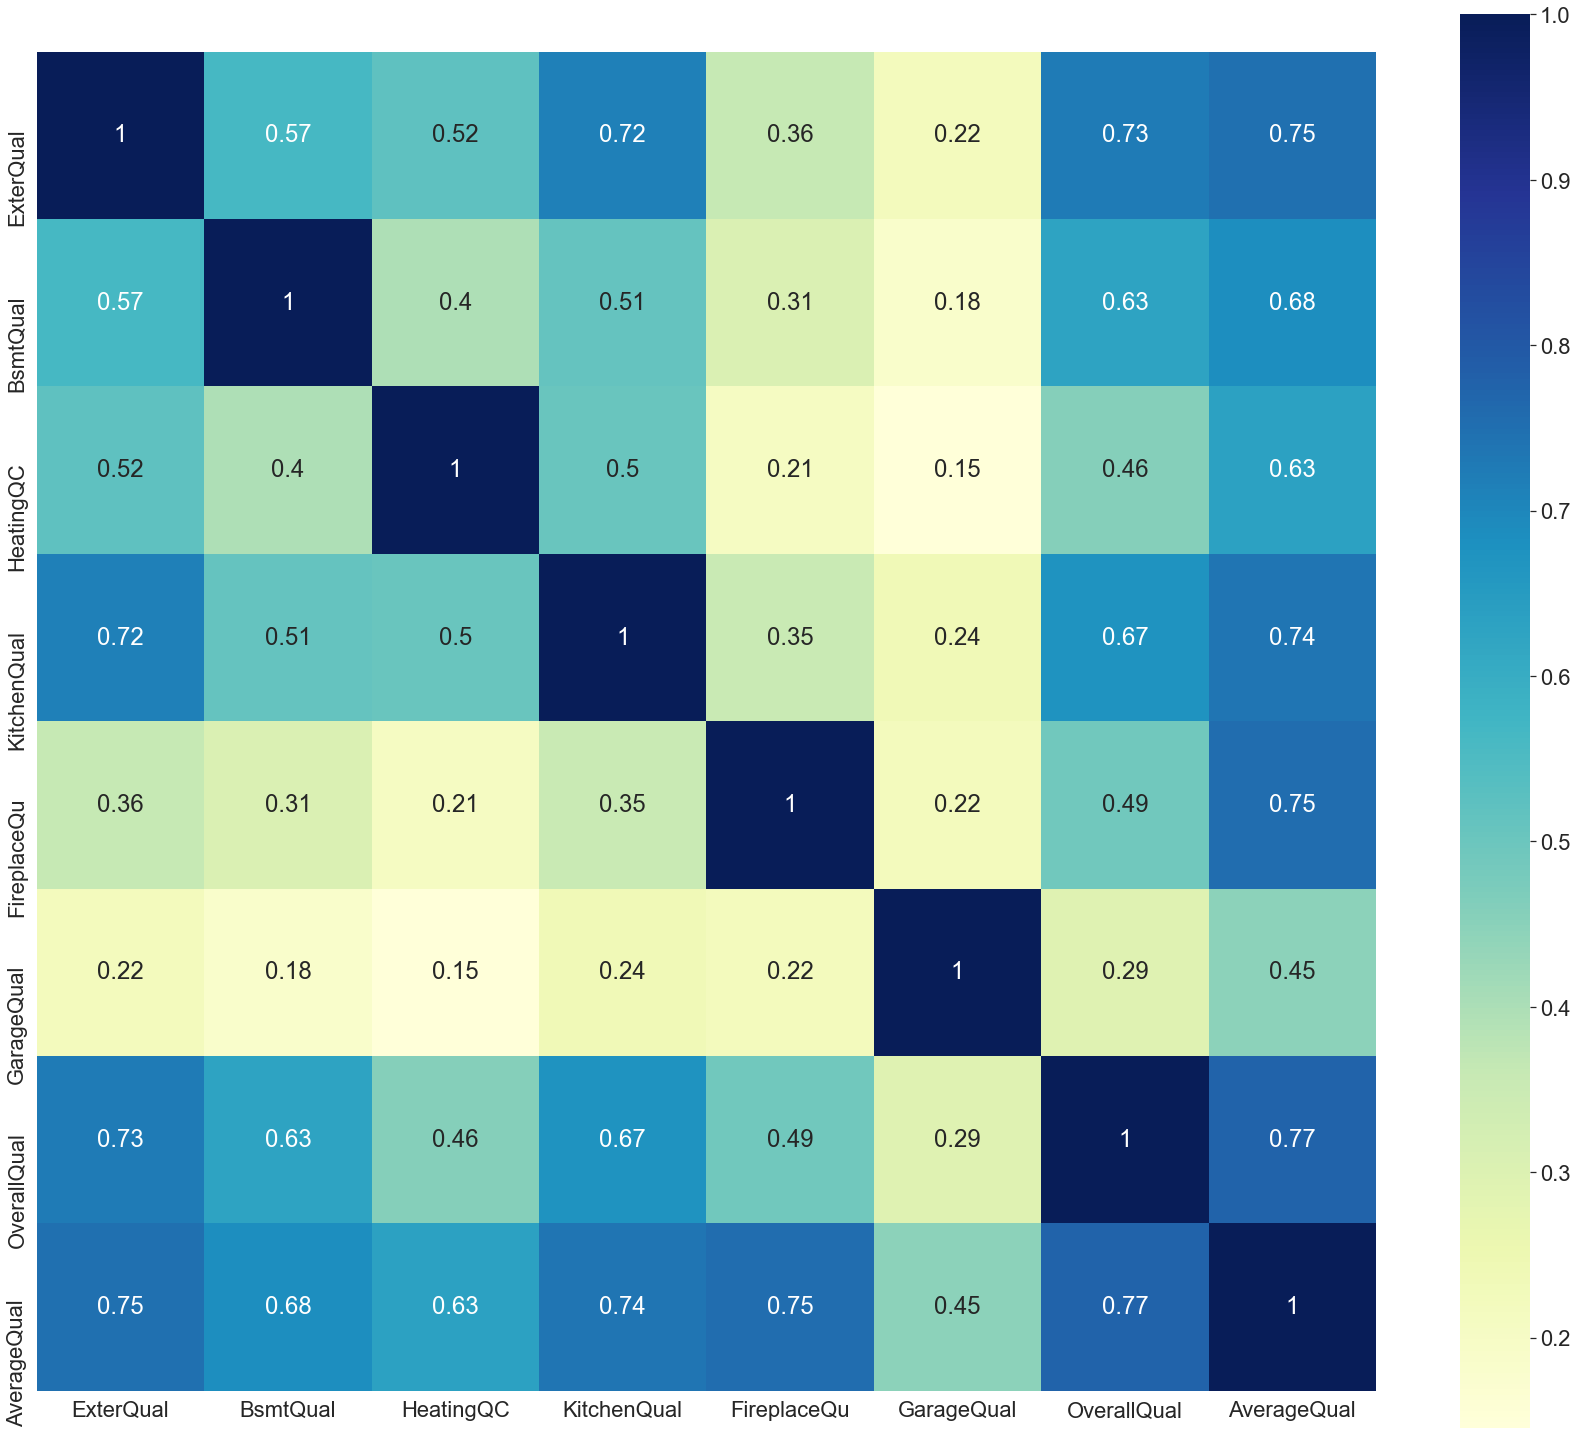

In [11]:
plt.figure(figsize=(30,26))
sns.set(font_scale=2)
all_qual_related = quality_columns + ['OverallQual', 'AverageQual']
sns.heatmap(features_df[all_qual_related].corr().abs(), annot=True, square=True, cmap="YlGnBu")
sns.set(font_scale=1)

In [12]:
# category_correlations = factorized_df[category_features + ['SalePrice']].corr().abs()['SalePrice']
# high_cat_correlations = category_correlations.loc[category_correlations > .2].index

# plt.figure(figsize=(24, 20))
# sns.heatmap(factorized_df[high_cat_correlations].corr().abs(), annot=True, square=True, cmap="YlGnBu")

# features = high_correlations.append(high_cat_correlations.drop('SalePrice'))

In [13]:
print(features_df.isna().sum().sort_values().tail(19))
X = features_df.drop(columns='SalePrice')
y = features_df['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

TotalBsmtSF     0
BsmtUnfSF       0
BsmtFinSF2      0
BsmtFinType2    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtExposure    0
BsmtCond        0
BsmtQual        0
Foundation      0
ExterCond       0
ExterQual       0
MasVnrArea      0
MasVnrType      0
Exterior2nd     0
Exterior1st     0
Electrical      0
AverageQual     0
GarageYrBlt     2
dtype: int64


In [14]:
model = xgb.XGBRegressor(
    max_depth=5,
    n_estimators=1000,
    min_child_weight=2, 
    colsample_bytree=.8, 
    subsample=0.8, 
    scale_pos_weight=1,
    sampling_method='uniform',
    eta=0.05,
    tree_method='gpu_hist',
    max_bin = 2048,
    seed=42,
    use_label_encoder=False,
    n_jobs=-1)

eval_metric = 'rmsle'

# parameters = {
# 'eta': np.arange(.05, .25, .05)
# }


# grid = GridSearchCV(model, parameters, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=2)
# grid.fit(X, y)

# print(grid.best_params_)

model.fit(
    X_train, 
    y_train, 
    eval_metric=eval_metric, 
    eval_set=[(X_train, y_train),(X_val, y_val)], 
    verbose=True,
    early_stopping_rounds=30
    )

[0]	validation_0-rmsle:2.99994	validation_1-rmsle:2.99254
[1]	validation_0-rmsle:2.32764	validation_1-rmsle:2.32353
[2]	validation_0-rmsle:1.94898	validation_1-rmsle:1.94192
[3]	validation_0-rmsle:1.68539	validation_1-rmsle:1.68397
[4]	validation_0-rmsle:1.48731	validation_1-rmsle:1.48307
[5]	validation_0-rmsle:1.33018	validation_1-rmsle:1.32467
[6]	validation_0-rmsle:1.19984	validation_1-rmsle:1.19409
[7]	validation_0-rmsle:1.09059	validation_1-rmsle:1.08605
[8]	validation_0-rmsle:0.99759	validation_1-rmsle:0.99418
[9]	validation_0-rmsle:0.91589	validation_1-rmsle:0.91336
[10]	validation_0-rmsle:0.84462	validation_1-rmsle:0.84186
[11]	validation_0-rmsle:0.78176	validation_1-rmsle:0.77917
[12]	validation_0-rmsle:0.72564	validation_1-rmsle:0.72289
[13]	validation_0-rmsle:0.67519	validation_1-rmsle:0.67215
[14]	validation_0-rmsle:0.62914	validation_1-rmsle:0.62584
[15]	validation_0-rmsle:0.58730	validation_1-rmsle:0.58539
[16]	validation_0-rmsle:0.54940	validation_1-rmsle:0.54856
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.05, gamma=0,
             gpu_id=0, importance_type='gain', interaction_constraints='',
             learning_rate=0.0500000007, max_bin=2048, max_delta_step=0,
             max_depth=5, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             sampling_method='uniform', scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='gpu_hist', use_label_encoder=False,
             validate_parameters=1, ...)

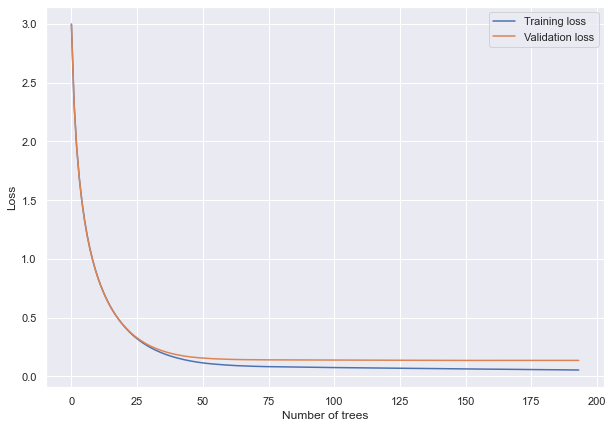

In [15]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"][eval_metric], label="Training loss")
plt.plot(results["validation_1"][eval_metric], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

<AxesSubplot:>

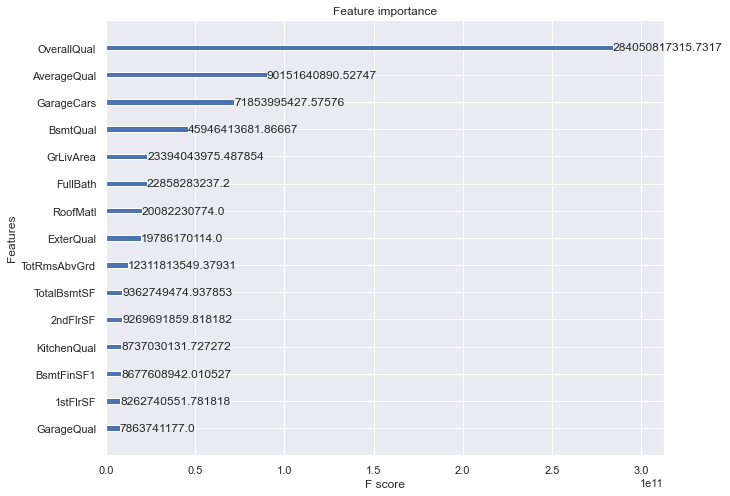

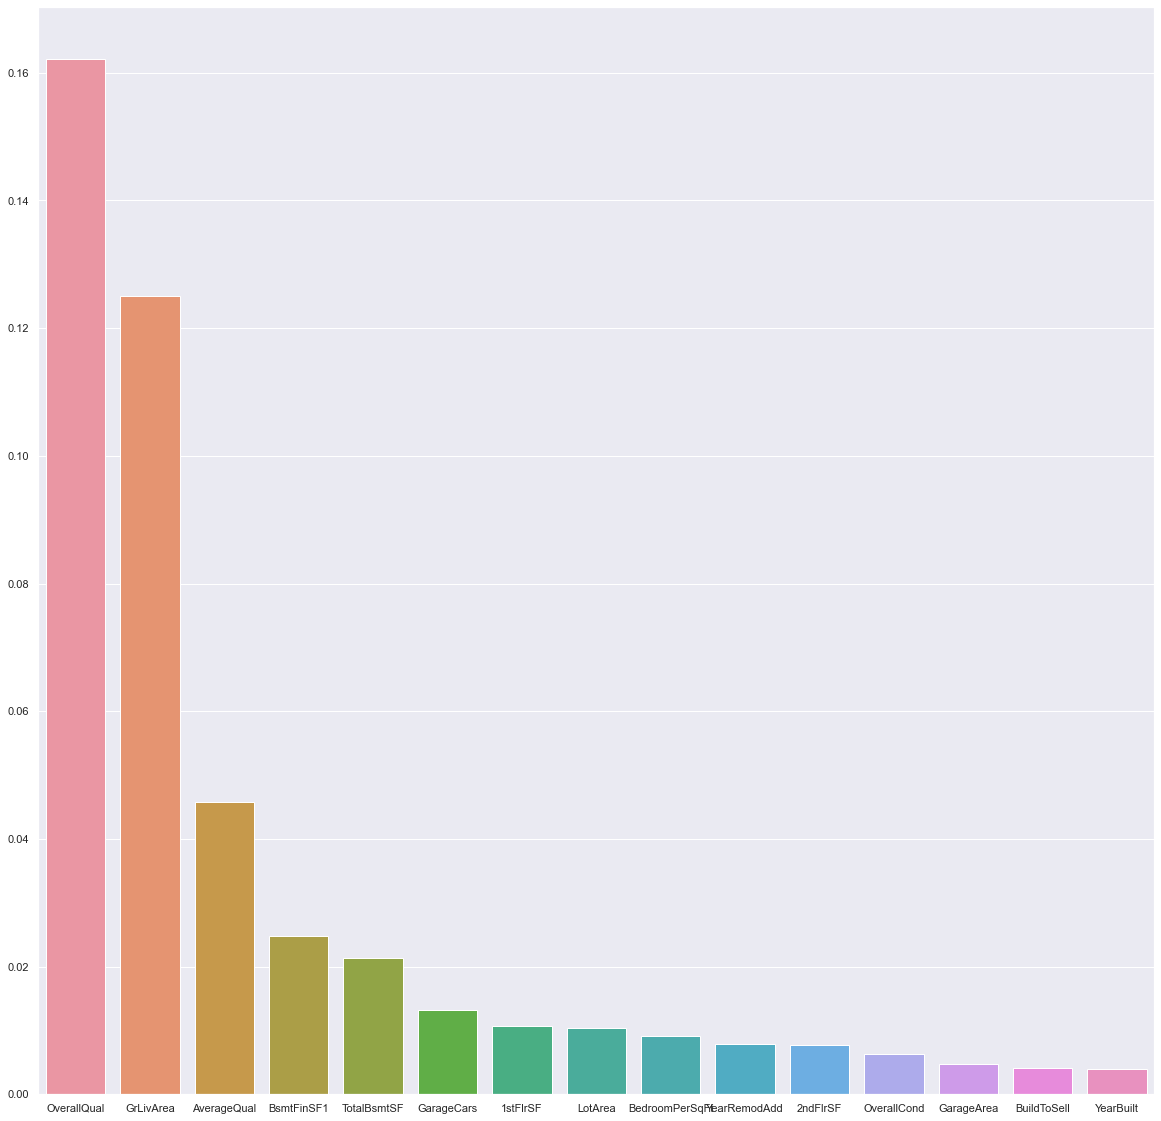

In [16]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax, importance_type='gain', max_num_features=15)

plot_features(model, (10,8))


plt.figure(figsize=(20,20))

importances = permutation_importance(model, X_train, y_train, random_state=42, n_repeats=10)
sorted_idx = importances.importances_mean.argsort()[::-1][:15]

sns.barplot(x=X.columns.to_numpy()[sorted_idx], y=importances.importances_mean[sorted_idx])

In [17]:
category_features = list(test_df.select_dtypes(include=['object']).columns)

test_encoded = encode_quality_columns(test_df)
factorized_test_df = factorize_categories(test_encoded, category_features)
filled_df = fill_na_values(factorized_test_df)
test_X = add_features(filled_df)

predictions = model.predict(test_X)
submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': predictions})

print(submission.info())
print('\n')
print(submission.nunique())
submission.to_csv('submission.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float32
dtypes: float32(1), int64(1)
memory usage: 17.2 KB
None


Id           1459
SalePrice    1459
dtype: int64
